# AVISO data in zarr

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


- i=0,1 :  jobs=6, cores = 26 
- i=2,3 :  jobs=1, cores = 26 
- i=4 :    jobs=1, cores = 10
- i=5 :    jobs=1, cores = 26
- i=6 :    jobs=4, cores = 26

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=4)
    #w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.56:8787/status,
Dashboard: http://10.148.1.56:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.56:51970,Workers: 0
Dashboard: http://10.148.1.56:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [23]:
def run_aviso_divided(l, Ng=10000) :
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    ds_data = ds_data.where(ds_data.alti___distance<2e5, drop=True)
    Nt = ds_data.dims['obs']
    N=0
    i=0
    L=[]
    while N <= Nt :
        #if not os.path.isdir(os.path.join(zarr_dir, "aviso_"+l+f"_{i}.zarr")):
        ds_data_ = ds_data.isel(obs=slice(N,min(N+Ng, Nt))).chunk({'obs':500, 'alti_time':-1, 'site_obs':-1})
        L.append(ds_data_)
            #ds_aviso = run_aviso_divided_one(ds_data_, i).persist()
            #store
            #zarr = os.path.join(zarr_dir, "aviso_"+l+f"_{i}.zarr")
            #ds_aviso.to_zarr(zarr, mode="w")  
            #print(f"aviso {l} group {i} storred in {zarr}")
        i+=1
        N+=Ng
    return L
            
def run_aviso_divided_one(ds_data, i):
    """main execution code"""

    # load or create dataset and do work
    # ds = ...
    # synthetic example here to compute pi:
    import dask.array as da
    ds_aviso = aviso.compute_aviso_sla(ds_data, dt=(-12,13), only_matchup_time = True).chunk({'obs':500, 'site_obs':-1})
    return ds_aviso

In [24]:
l = labels[0]
L = run_aviso_divided(l)

In [25]:
len(L)

4

In [15]:
ds= L[4]
dt=(-12, 13)
template = aviso._concat_aviso(ds.isel(obs=slice(0, 2)), dt=dt, only_matchup_time=True)
template.persist()

ValueError: must supply at least one object to concatenate

In [8]:
ds_aviso = aviso.compute_aviso_sla(ds_data, dt=(-12, 13), only_matchup_time=True).persist()
zarr = os.path.join(zarr_dir, "aviso_"+l+".zarr")
print('3')
#ds_aviso.to_zarr(zarr, mode="w")
ds_aviso.to_zarr(zarr, mode="a", append_dim='obs')
print(f"aviso {l} storred in {zarr}")

3
aviso gps_Sentinel-3_A_2019 storred in /home/datawork-lops-osi/aponte/margot/historical_coloc/aviso_gps_Sentinel-3_A_2019.zarr


## Open Test

In [5]:
l = labels[0]
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr').persist()

In [6]:
dsdd = ds_data.where(ds_data.alti___distance<2e5, drop=True).persist()

In [17]:
f = glob(os.path.join(zarr_dir, f'aviso_*{l}*.zarr'))

In [14]:
for fi in f :
    print(xr.open_dataset(fi).dims['obs'])

10000
10000
10000
6694


In [22]:
dsdd.isel(obs=slice(30000,-1))

<xarray.Dataset>
Dimensions:                                       (obs: 6693, alti_time: 211,
                                                   alti_time_mid: 210,
                                                   box_y: 80, box_x: 120,
                                                   site_obs: 1489)
Coordinates: (12/20)
    alti_lat                                      (obs, alti_time) float64 dask.array<chunksize=(229, 211), meta=np.ndarray>
    alti_lon                                      (obs, alti_time) float64 dask.array<chunksize=(229, 211), meta=np.ndarray>
  * alti_time                                     (alti_time) int64 0 1 ... 210
    alti_time_                                    (obs, alti_time) datetime64[ns] dask.array<chunksize=(2084, 27), meta=np.ndarray>
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x                                        (obs, alti_time) float64 dask.array<chunksize=(229, 211), meta=np.ndarray>
    ...                                            ...
    drifter_x                                     (obs, site_obs) float64 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    drifter_y                                     (obs, site_obs) float64 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    lat                                           (obs) float64 dask.array<chunksize=(229,), meta=np.ndarray>
    lon                                           (obs) float64 dask.array<chunksize=(229,), meta=np.ndarray>
  * obs                                           (obs) int64 35210 ... 43071
    time                                          (obs) datetime64[ns] dask.array<chunksize=(6693,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/68)
    __site_id                                     (obs) object dask.array<chunksize=(229,), meta=np.ndarray>
    __site_matchup_indice                         (obs) float64 dask.array<chunksize=(229,), meta=np.ndarray>
    __site_name                                   (obs) object dask.array<chunksize=(229,), meta=np.ndarray>
    alti___distance                               (obs) float64 dask.array<chunksize=(229,), meta=np.ndarray>
    alti___source                                 (obs) object dask.array<chunksize=(229,), meta=np.ndarray>
    alti___source_center_index                    (obs) object dask.array<chunksize=(229,), meta=np.ndarray>
    ...                                            ...
    drifter_typedeath                             (obs, site_obs) float64 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    drifter_ve                                    (obs, site_obs) float32 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    drifter_vn                                    (obs, site_obs) float32 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    drifter_vx                                    (obs, site_obs) float64 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    drifter_vy                                    (obs, site_obs) float64 dask.array<chunksize=(229, 1489), meta=np.ndarray>
    f                                             (obs) float64 dask.array<chunksize=(229,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__gps
    __time_coverage_end:    2020-05-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

In [21]:
xr.open_dataset(f[3])

<xarray.Dataset>
Dimensions:                        (obs: 6694, box_y: 80, box_x: 120,
                                    aviso_time: 25, site_obs: 1489)
Coordinates:
    aviso_time_                    (obs, aviso_time) datetime64[ns] ...
  * box_x                          (box_x) float64 -3e+05 -2.95e+05 ... 2.95e+05
  * box_y                          (box_y) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * obs                            (obs) int64 35210 35211 35212 ... 43071 43072
Dimensions without coordinates: aviso_time, site_obs
Data variables: (12/32)
    aviso_alti_matchup_adt         (obs) float64 ...
    aviso_alti_matchup_err_sla     (obs) float64 ...
    aviso_alti_matchup_ggx_adt     (obs) float64 ...
    aviso_alti_matchup_ggx_sla     (obs) float64 ...
    aviso_alti_matchup_ggy_adt     (obs) float64 ...
    aviso_alti_matchup_ggy_sla     (obs) float64 ...
    ...                             ...
    aviso_traj_ggy_adt             (obs, site_obs) float64 ...
    aviso_traj_ggy_sla             (obs, site_obs) float64 ...
    aviso_traj_sla                 (obs, site_obs) float64 ...
    drifter_time                   (obs, site_obs) datetime64[ns] ...
    drifter_x                      (obs, site_obs) float64 ...
    drifter_y                      (obs, site_obs) float64 ...
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

In [11]:
dsa_ = dsa.isel(obs=3).compute()

In [16]:
def open_aviso(l) : 
    files = glob(os.path.join(zarr_dir, f'aviso_*{l}_*.zarr'))
    ds = xr.concat([xr.open_dataset(f).persist() for f in files], dim='obs')
    return ds
ds = open_aviso(l)

KeyboardInterrupt: 

In [5]:
ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name']=ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name'].replace(' matchup', 'matchup')

In [6]:
ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name']

'$g\\partial_x\\eta_{driftermatchup}$'

#pb attrs
i=6
l=labels[i]
ds_aviso_test = xr.open_zarr(cstes.zarr_dir+'/aviso_'+l+'.zarr').persist()
for v in ds_aviso_test:
     if 'matchup' in v:
            ds_aviso_test[v].attrs['long_name']=ds_aviso_test[v].attrs['long_name'].replace(' matchup', 'matchup')
zarr = os.path.join(zarr_dir, "aviso_"+l+".zarr")
ds_aviso_test.to_zarr(zarr, mode="w")
print(f"aviso {l} storred in {zarr}")

In [11]:
ds_aviso_test

<xarray.Dataset>
Dimensions:                             (obs: 73334, box_y: 40, box_x: 80,
                                         aviso_time: 3, site_obs: 1489)
Coordinates:
    aviso_time_                         (obs, aviso_time) datetime64[ns] dask.array<chunksize=(18334, 2), meta=np.ndarray>
  * box_x                               (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                               (box_y) float64 -1e+05 ... 9.5e+04
    time                                (obs) datetime64[ns] dask.array<chunksize=(36667,), meta=np.ndarray>
Dimensions without coordinates: obs, aviso_time, site_obs
Data variables: (12/31)
    aviso_alti_matchup_adt              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_err_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                  ...
    aviso_traj_g_grad_x                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_g_grad_y                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_sla                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                        (obs, site_obs) datetime64[ns] dask.array<chunksize=(2292, 94), meta=np.ndarray>
    drifter_x                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

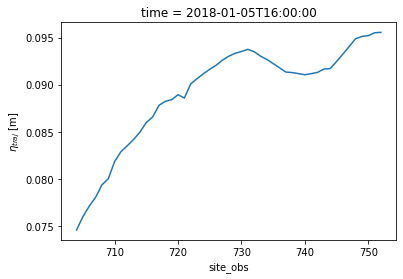

In [9]:
ds_aviso_test.isel(obs=0).aviso_traj_sla.plot()

In [10]:
ds_aviso_test

<xarray.Dataset>
Dimensions:                         (obs: 12077, box_y: 40, box_x: 80,
                                     aviso_time: 3, site_obs: 1489)
Coordinates:
    aviso_time_                     (obs, aviso_time) datetime64[ns] dask.array<chunksize=(6039, 3), meta=np.ndarray>
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
    time                            (obs) datetime64[ns] dask.array<chunksize=(12077,), meta=np.ndarray>
Dimensions without coordinates: obs, aviso_time, site_obs
Data variables: (12/19)
    aviso_alti_matchup_err_sla      (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_box_err_sla               (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    aviso_box_g_grad_x              (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    ...                              ...
    aviso_traj_g_grad_x             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_g_grad_y             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_sla                  (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                    (obs, site_obs) datetime64[ns] dask.array<chunksize=(755, 187), meta=np.ndarray>
    drifter_x                       (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                       (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

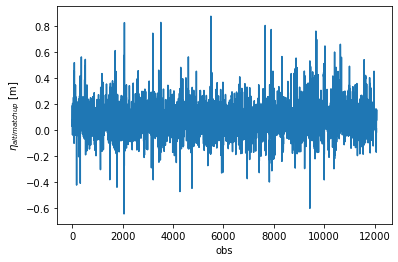

In [11]:
ds_aviso_test.aviso_alti_matchup_sla.plot()

In [26]:
cluster.close()

In [5]:
[l for l in labels if not os.path.isdir(os.path.join(zarr_dir, "aviso_"+l+".zarr"))]

['argos_Jason-2_2011',
 'argos_Jason-2_2010',
 'gps_Cryosat-2_2010',
 'argos_Cryosat-2_2010',
 'argos_Jason-2_2009',
 'argos_Jason-2_2008']